In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from aerometrics.utils.functions import emission_profile_function
from aerometrics.metrics.metrics import co2_ipcc_pulse_absolute_metrics, absolute_metrics, relative_metrics
from aerometrics.climate_models.co2_ipcc_climate_model import co2_ipcc_climate_model
from aerometrics.climate_models.gwpstar_climate_model import species_gwpstar_climate_model
from aerometrics.climate_models.lwe_climate_model import species_lwe_climate_model
from aerometrics.climate_models.fair_climate_model import background_species_quantities_function, species_fair_climate_model

## Parameters

In [2]:
climate_model = "FaIR" # "GWP*", "LWE, "FaIR"
co2_method = 'FaIR' # IPCC or FaIR
profile = "pulse"

if climate_model == "FaIR":
    start_year = 1765
else:
    start_year = 2000
t0 = 2020

if climate_model == "GWP*" or climate_model == "LWE":
    tcre = 0.00045

settings = "Lee" # "Lee", "Bickel"

## Metrics calculation

In [3]:
j = 0
time_horizon_range = range(15,110,5)
gwp_rf = np.zeros((len(time_horizon_range),6))
gwp_erf = np.zeros((len(time_horizon_range),6))
egwp_rf = np.zeros((len(time_horizon_range),6))
egwp_erf = np.zeros((len(time_horizon_range),6))
gtp = np.zeros((len(time_horizon_range),6))
ratr = np.zeros((len(time_horizon_range),6))

sensitivity_rf_co2 = 9.2e-16 # Not used with FaIR
ratio_erf_rf_co2 = 1
efficacy_erf_co2 = 1
unit_value_co2 = 1*10**10

for species in ["Aviation contrails", "Aviation NOx - ST O3 increase", "Aviation NOx - CH4 decrease and induced", "Aviation H2O", "Aviation soot", "Aviation sulfur"]:
    
    if species == "Aviation contrails":
        unit_value = 1*10**10
        sensitivity_rf = 2.23e-12
        if settings == "Lee":
            ratio_erf_rf = 0.42
            efficacy_erf = 1
        elif settings == "Bickel":
            ratio_erf_rf = 0.55
            efficacy_erf = 0.38
    elif species == "Aviation NOx - ST O3 increase":
        unit_value = 1*10**10
        sensitivity_rf = 25.1e-12 * (14/46)
        ratio_erf_rf = 1.37
        efficacy_erf = 1
    elif species == "Aviation NOx - CH4 decrease and induced":
        unit_value = 1*10**10
        sensitivity_rf = -3.90
        ratio_erf_rf = 1.18
        efficacy_erf = 1
    elif species == "Aviation H2O":
        unit_value = 1*10**12
        sensitivity_rf = 0.0052e-12
        ratio_erf_rf = 1
        efficacy_erf = 1
    elif species == "Aviation soot":
        unit_value = 1*10**14
        sensitivity_rf = 100.7e-12 # Not used
        ratio_erf_rf = 1
        efficacy_erf = 1
    elif species == "Aviation sulfur":
        unit_value = 1*10**10
        sensitivity_rf = -19.9e-12 # Not used
        ratio_erf_rf = 1
        efficacy_erf = 1
    
    unit_value_co2 = 1*10**10
    
    k = 0
    for time_horizon in time_horizon_range:
        end_year = t0 + time_horizon
        if climate_model == "FaIR" or co2_method == "FaIR":
            background_species_quantities = background_species_quantities_function(start_year, end_year, rcp='RCP45')
        
        emission_profile_co2 = emission_profile_function(start_year,t0,time_horizon, profile, unit_value_co2)
        emission_profile = emission_profile_function(start_year,t0,time_horizon, profile, unit_value)
        
        if co2_method == 'IPCC':
            agwp_rf_co2, agwp_erf_co2, aegwp_rf_co2, aegwp_erf_co2, agtp_co2, iagtp_co2, atr_co2 = co2_ipcc_pulse_absolute_metrics(time_horizon)
        elif co2_method == 'FaIR':
            species_settings_co2 = {"sensitivity_rf": sensitivity_rf_co2, "ratio_erf_rf": ratio_erf_rf_co2, "efficacy_erf": efficacy_erf_co2}
            model_settings_co2 = {"background_species_quantities": background_species_quantities}
            radiative_forcing_co2, effective_radiative_forcing_co2, temperature_co2 = species_fair_climate_model(start_year, end_year, "Aviation CO2", emission_profile_co2, species_settings_co2, model_settings_co2)
            radiative_forcing_co2_unit, effective_radiative_forcing_co2_unit, temperature_co2_unit = radiative_forcing_co2/unit_value_co2, effective_radiative_forcing_co2/unit_value_co2, temperature_co2/unit_value_co2
            agwp_rf_co2, agwp_erf_co2, aegwp_rf_co2, aegwp_erf_co2, agtp_co2, iagtp_co2, atr_co2 = absolute_metrics(radiative_forcing_co2_unit, effective_radiative_forcing_co2_unit, efficacy_erf_co2, temperature_co2_unit, time_horizon)
        if climate_model == "GWP*":
            species_settings = {"sensitivity_rf": sensitivity_rf, "ratio_erf_rf": ratio_erf_rf, "efficacy_erf": efficacy_erf}
            model_settings = {"tcre": tcre}
            radiative_forcing, effective_radiative_forcing, temperature = species_gwpstar_climate_model(start_year, end_year, species, emission_profile, species_settings, model_settings)
        elif climate_model == "LWE":
            species_settings = {"sensitivity_rf": sensitivity_rf, "ratio_erf_rf": ratio_erf_rf, "efficacy_erf": efficacy_erf}
            model_settings = {"tcre": tcre}
            radiative_forcing, effective_radiative_forcing, temperature = species_lwe_climate_model(start_year, end_year, species, emission_profile, species_settings, model_settings)
        elif climate_model == "FaIR":
            species_settings = {"sensitivity_rf": sensitivity_rf, "ratio_erf_rf": ratio_erf_rf, "efficacy_erf": efficacy_erf}
            model_settings = {"background_species_quantities": background_species_quantities}
            radiative_forcing, effective_radiative_forcing, temperature = species_fair_climate_model(start_year, end_year, species, emission_profile, species_settings, model_settings)
        radiative_forcing_unit, effective_radiative_forcing_unit, temperature_unit = radiative_forcing/unit_value, effective_radiative_forcing/unit_value, temperature/unit_value
        agwp_rf, agwp_erf, aegwp_rf, aegwp_erf, agtp, iagtp, atr = absolute_metrics(radiative_forcing_unit, effective_radiative_forcing_unit, efficacy_erf, temperature_unit, time_horizon)
        
        gwp_rf[k,j], gwp_erf[k,j], egwp_rf[k,j], egwp_erf[k,j], gtp[k,j], igtp, ratr[k,j] = relative_metrics(agwp_rf_co2, agwp_erf_co2, aegwp_rf_co2, aegwp_erf_co2, agtp_co2, iagtp_co2, atr_co2, agwp_rf, agwp_erf, aegwp_rf, aegwp_erf, agtp, iagtp, atr)
        
        k += 1
        
    j += 1

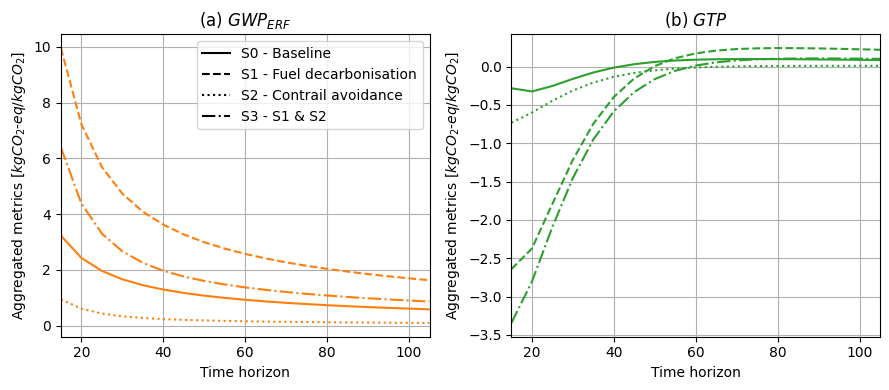

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

# Ratio based on 2018 data
ratio_contrails = 61.3/1033.7 # Million km / MtCO2
ratio_nox = 1.4*46/14/1033.7 # MtNOx / MtCO2
ratio_h2o = 382.55/1033.7 # MtH2O / MtCO2
ratio_soot = 0.0093/1033.7 # MtBC / MtCO2
ratio_sulfur = 0.37/1033.7 # MtSOx / MtCO2

# S1 - Fuel decarbonisation (including effect on contrails with sqrt(0.2))
ratio_contrails_1 = 0.447*61.3/(1033.7*0.2) # Million km / MtCO2
ratio_nox_1 = 1.4*46/14/(1033.7*0.2) # MtNOx / MtCO2
ratio_h2o_1 = 382.55/(1033.7*0.2) # MtH2O / MtCO2
ratio_soot_1 = 0.2*0.0093/(1033.7*0.2) # MtBC / MtCO2
ratio_sulfur_1 = 0*0.37/(1033.7*0.2) # MtkSOx / MtCO2

# S2 - Contrail avoidance
ratio_contrails_2 = (1-0.8)*61.3/(1033.7*1.02) # Million km / MtCO2
ratio_nox_2 = 1.4*46/14/1033.7 # MtNOx / MtCO2
ratio_h2o_2 = 382.55/1033.7 # MtH2O / MtCO2
ratio_soot_2 = 0.0093/1033.7 # MtBC / MtCO2
ratio_sulfur_2 = 0.37/1033.7 # MtSOx / MtCO2

# S3 - S1 & S2
ratio_contrails_3 = (1-0.8)*61.3/(1033.7*0.2*1.02) # Million km / MtCO2
ratio_nox_3 = 1.4*46/14/(1033.7*0.2) # MtNOx / MtCO2
ratio_h2o_3 = 382.55/(1033.7*0.2) # MtH2O / MtCO2
ratio_soot_3 = 0.2*0.0093/(1033.7*0.2) # MtBC / MtCO2
ratio_sulfur_3 = 0*0.37/(1033.7*0.2) # MtSOx / MtCO2

for i, ax in enumerate(axes.flat):
    if i == 0:
        x_axis = time_horizon_range
        ax.plot(x_axis, ratio_contrails*gwp_erf[:, i+0]+ratio_nox*(gwp_erf[:, i+2]+gwp_erf[:, i+1])+ratio_h2o*gwp_erf[:, i+3]+ratio_soot*gwp_erf[:, i+4]+ratio_sulfur*gwp_erf[:, i+5], label='S0 - Baseline', color='C1')
        ax.plot(x_axis, ratio_contrails_1*gwp_erf[:, i+0]+ratio_nox_1*(gwp_erf[:, i+2]+gwp_erf[:, i+1])+ratio_h2o_1*gwp_erf[:, i+3]+ratio_soot_1*gwp_erf[:, i+4]+ratio_sulfur_1*gwp_erf[:, i+5], label='S1 - Fuel decarbonisation', color='C1', linestyle="--")
        ax.plot(x_axis, ratio_contrails_2*gwp_erf[:, i+0]+ratio_nox_2*(gwp_erf[:, i+2]+gwp_erf[:, i+1])+ratio_h2o_2*gwp_erf[:, i+3]+ratio_soot_2*gwp_erf[:, i+4]+ratio_sulfur_2*gwp_erf[:, i+5], label='S2 - Contrail avoidance', color='C1', linestyle=":")
        ax.plot(x_axis, ratio_contrails_3*gwp_erf[:, i+0]+ratio_nox_3*(gwp_erf[:, i+2]+gwp_erf[:, i+1])+ratio_h2o_3*gwp_erf[:, i+3]+ratio_soot_3*gwp_erf[:, i+4]+ratio_sulfur_3*gwp_erf[:, i+5], label='S3 - S1 & S2', color='C1', linestyle="-.")
        legend = ax.legend() 
        for legline in legend.get_lines():
            legline.set_color("black")
        ax.set_ylabel(r'Aggregated metrics [$kgCO_2\text{-}eq/kgCO_2$]')
        ax.set_title(r'(a) $GWP_{ERF}$')
    elif i == 1:
        i = 0
        x_axis = time_horizon_range
        ax.plot(x_axis, ratio_contrails*gtp[:, i+0]+ratio_nox*(gtp[:, i+2]+gtp[:, i+1])+ratio_h2o*gtp[:, i+3]+ratio_soot*gtp[:, i+4]+ratio_sulfur*gtp[:, i+5], label='S0', color='C2')
        ax.plot(x_axis, ratio_contrails_1*gtp[:, i+0]+ratio_nox_1*(gtp[:, i+2]+gtp[:, i+1])+ratio_h2o_1*gtp[:, i+3]+ratio_soot_1*gtp[:, i+4]+ratio_sulfur_1*gtp[:, i+5], label='S1', color='C2', linestyle="--")
        ax.plot(x_axis, ratio_contrails_2*gtp[:, i+0]+ratio_nox_2*(gtp[:, i+2]+gtp[:, i+1])+ratio_h2o_2*gtp[:, i+3]+ratio_soot_2*gtp[:, i+4]+ratio_sulfur_2*gtp[:, i+5], label='S2', color='C2', linestyle=":")
        ax.plot(x_axis, ratio_contrails_3*gtp[:, i+0]+ratio_nox_3*(gtp[:, i+2]+gtp[:, i+1])+ratio_h2o_3*gtp[:, i+3]+ratio_soot_3*gtp[:, i+4]+ratio_sulfur_3*gtp[:, i+5], label='S3', color='C2', linestyle="-.")
        #ax.legend()
        ax.set_ylabel(r'Aggregated metrics [$kgCO_2\text{-}eq/kgCO_2$]')
        ax.set_title(r'(b) $GTP$')
    ax.set_xlim(min(time_horizon_range),max(time_horizon_range))
    ax.set_xlabel('Time horizon')
    ax.grid(True)
plt.tight_layout()
plt.savefig("figures/sensitivity_to_scenarios.pdf")
plt.show()